In [1]:
import random
from typing import List
import torch
import torch.nn as nn
import numpy as np
import pickle
import re

In [35]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
# device = torch.device('cpu')
print(device)

cuda


### Tokenizer, TokenEmbedding, PositionalEncoding

In [36]:
#Init dictionary
class Tokenizer:
    
    def __init__(self):
        self.dictionary = {}
        self.reverse_dictionary = {}
        
        # add padding token
        self.__add_to_dict('<pad>')

        for i in range(10):
            self.__add_to_dict(str(i))
        for i in range(26):
            self.__add_to_dict(chr(ord('a') + i))
            
        self.__add_to_dict(".")
        self.__add_to_dict(" ")
        self.__add_to_dict("'")
        
    def __add_to_dict(self, character):
        if character not in self.dictionary:
            self.dictionary[character] = len(self.dictionary)
            self.reverse_dictionary[self.dictionary[character]] = character
    
    def tokenize(self, text):
        return [self.dictionary[c] for c in text]
    
    def character_to_token(self, character):
        return self.dictionary[character]
    
    def token_to_character(self, token):
        return self.reverse_dictionary[token]
    
    def size(self):
        return len(self.dictionary)

class TokenEmbedding(nn.Module):
    """Conver input to embedding
    Bigger embedding mean more information but requires more time to train
    
    Input dimension : (batch_size, sequence_length)
    Output dimension : (batch_size, sequence_length, embedding_dimension)
    """
    
    def __init__(self, n_embedding, n_token):
        super().__init__()
        self.embedding_layer = nn.Embedding(n_token, n_embedding)
    
    def forward(self, x):
        return self.embedding_layer(x)
    

class PositionalEncoding(nn.Module):
    """Create positional embedding with same dimensions as token embedding
    """
    
    def __init__(self, n_embedding, max_sequence_length):
        super().__init__()
        self.n_embedding = n_embedding
        self.n_token = max_sequence_length
        self.positional_encoding = self.create_positional_embedding()
        
    def create_positional_embedding(self):
        """create positional encoding matrix of size (n_token, n_embedding)
        """
        positional_encoding = np.zeros((self.n_token, self.n_embedding))
        for pos in range(self.n_token):
            for i in range(0, self.n_embedding, 2):
                positional_encoding[pos, i] = np.sin(pos / (10_000 ** ((2 * i) / self.n_embedding)))
                positional_encoding[pos, i+1] = np.cos(pos / (10_000 ** ((2 * (i+1)) / self.n_embedding)))
        return torch.from_numpy(positional_encoding).float().to(device)
    
    def forward(self, x):
        return x + self.positional_encoding[: x.size(1), :]
 

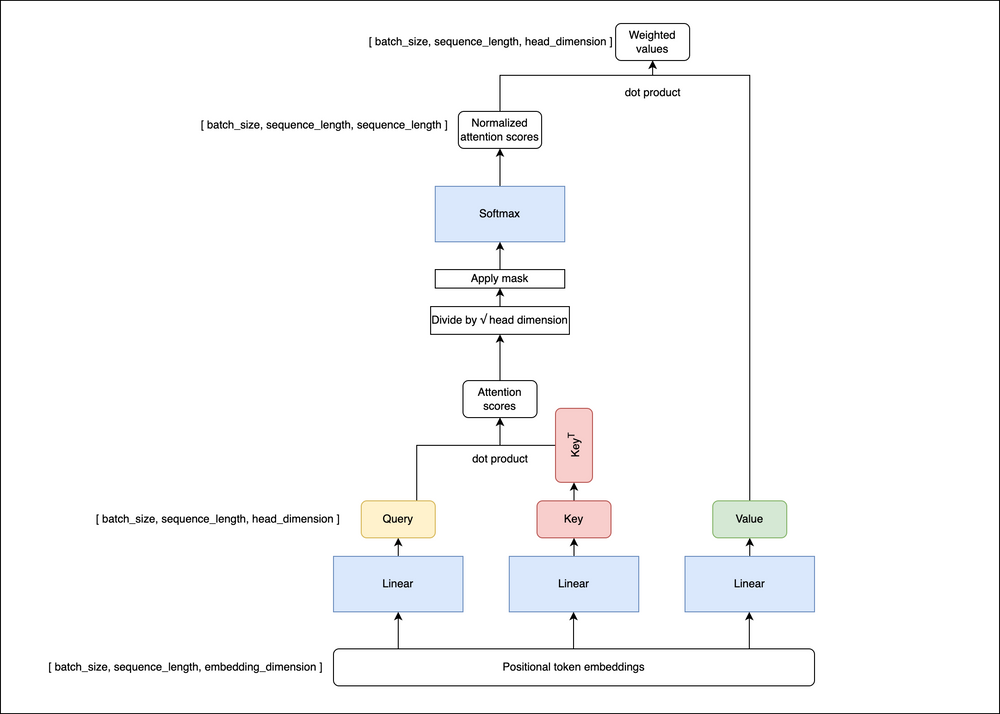
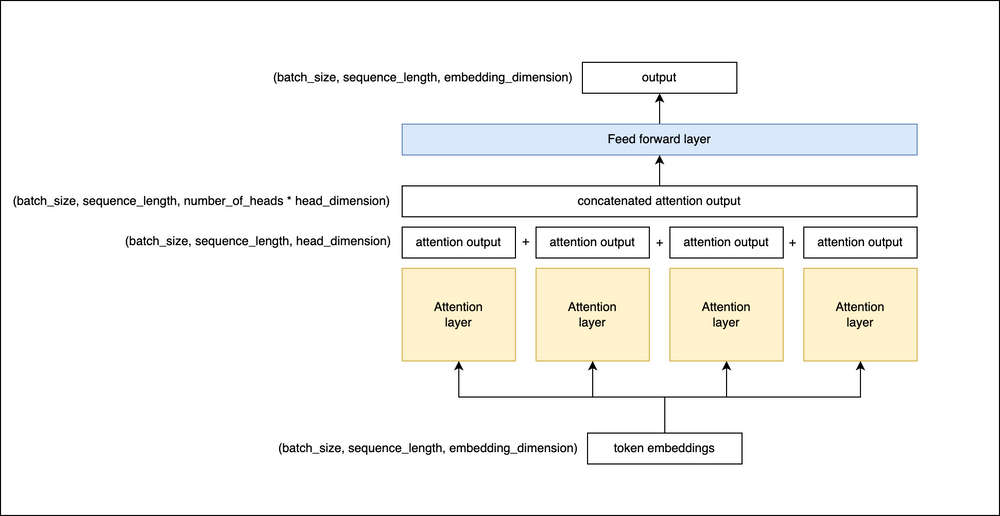

### SelfAttentionHeads

In [37]:


class MaskedSelfAttention(nn.Module):
    """ Single head of self attention head

    Input dimension: (batch_size, n_token, n_embedding)
    Output dimension: (batch_size, n_token, n_head)
    """
    
    def __init__(self, n_embedding, n_head_dimension):
        super().__init__()
        self.n_embedding = n_embedding
        self.n_head_dimension = n_head_dimension
        
        self.query_layer = nn.Linear(n_embedding, n_head_dimension)
        self.key_layer = nn.Linear(n_embedding, n_head_dimension)
        self.value_layer = nn.Linear(n_embedding, n_head_dimension)
        #TODO: Add dropout layer to attention head
        
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x, mask):
        """
        Compute the self attention.

        x dimension is: (batch_size, n_token, n_embedding)
        output dimension is: (batch_size, n_token, n_head)
        mask dimension is: (batch_size, n_token)

        mask values are: 0 or 1. 0 means the token is masked, 1 means the token is not masked.
        """
        # x dimensions are: (batch_size, n_token, n_embedding)
        # query, key, value dimensions are: (batch_size, n_token, n_head_dimension)
        query = self.query_layer(x)
        key = self.key_layer(x)
        value = self.value_layer(x)
        
        # Calculate the attention weights.
        # attention_weights dimensions are: (batch_size, n_token, n_token)
        attention_weights = torch.matmul(query, key.transpose(-2, -1))
        # Scale the attention weights.
        attention_weights = attention_weights / np.sqrt(self.n_head_dimension)
        
        # Apply the mask to the attention weights, by setting the masked tokens to a very low value.
        # This will make the softmax output 0 for these values.
        mask = mask.reshape(attention_weights.shape[0], 1, attention_weights.shape[2])
        attention_weights = attention_weights.masked_fill(mask == 0, -1e9)
        
        # Softmax makes sure all scores are between 0 and 1 and the sum of scores is 1.
        # attention_scores dimensions are: (batch_size, n_token, n_token)
        attention_scores = self.softmax(attention_weights)
        #TODO: dropout
        
        # The attention scores are multiplied by the value
        # Values of tokens with high attention score get highlighted because they are multiplied by a larger number,
        # and tokens with low attention score get drowned out because they are multiplied by a smaller number.
        # Output dimensions are: (batch_size, n_token, n_head_dimension)
        return torch.bmm(attention_scores, value)
    

class MaskedMultiheadSelfAttention(nn.Module):
    """module for multi head attention layer

    Input dimension is: (batch_size, n_toklen, n_embedding)
    Output dimension is: (batch_size, n_toklen, n_embedding)
    """
    
    def __init__(self, n_embedding, n_head):
        super().__init__()
        self.n_embedding = n_embedding
        self.n_head = n_head
        self.head_dimension = n_embedding // n_head
        
        self.self_attention_heads = nn.ModuleList(
            [MaskedSelfAttention(self.n_embedding, self.head_dimension) for _ in range(n_head)]
        )
        
        self.output_layer = nn.Linear(self.n_head * self.head_dimension, self.n_embedding)
        
    def forward(self, x, mask):
        """Compute multi head attention
        
        x dimensions: (batch_size, n_token, n_embedding)
        mask dimensions: (batch_size, n_token)
        mask values: 0 or 1. 0 means token is masked, 1 means token is not masked
        """
        # compute self attention for each head: (n_head, batch_size, n_token, n_head_dimension)
        self_attention_outputs = [self_attention(x, mask) for self_attention in self.self_attention_heads]
        
        # concatenate self attenion output: (batch_size, n_token, n_head * n_head_dimension)
        concatenated_self_attention_outputs = torch.cat(self_attention_outputs, dim=2)
        
        # apply linear layer to output: (batch_size, n_token, n_embedding)
        return self.output_layer(concatenated_self_attention_outputs)

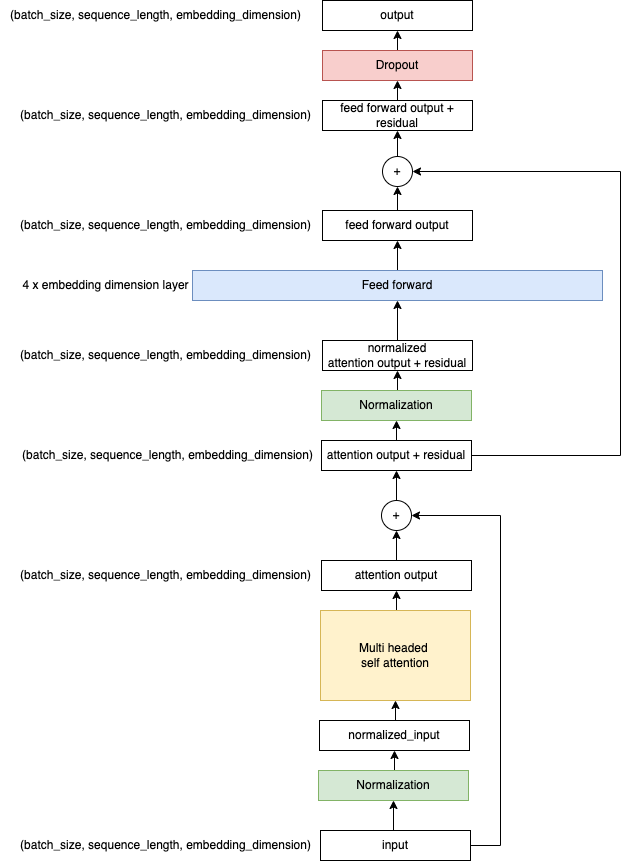

### DecoderStack, FeedForward and LanguageModel

In [38]:


class DecoderLayer(nn.Module):
    
    def __init__(self, n_embedding, n_head, feed_forward_dimension, dropout_rate):
        super().__init__()
        self.n_embedding = n_embedding
        self.n_head = n_head
        self.feed_forward_dimension = feed_forward_dimension
        self.dropout_rate = dropout_rate
        self.training = True
        
        self.multi_head_self_attention = MaskedMultiheadSelfAttention(n_embedding, n_head)
        self.feed_forward = FeedForward(n_embedding, feed_forward_dimension)
        self.dropout = nn.Dropout(dropout_rate)
        self.norm_1 = nn.LayerNorm(n_embedding)
        self.norm_2 = nn.LayerNorm(n_embedding)
        
    def forward(self, x, mask):
        normalized_x = self.norm_1(x) 
        attention_output = self.multi_head_self_attention(normalized_x, mask) # same dimension as x
        residual_output = x + attention_output
        normalized_residual = self.norm_2(residual_output)
        feed_forward_output = self.feed_forward(normalized_residual)
        
        if self.training:
            feed_forward_output = self.dropout(feed_forward_output)
            
        return feed_forward_output + residual_output

    
class DecoderStack(nn.Module):
    

    def __init__(self, n_embedding, n_layers, n_head, feed_forward_dimension, dropout_rate):
        super().__init__()
        self.n_embedding = n_embedding
        self.n_layers = n_layers
        self.n_head = n_head
        self.feed_forward_dimension = feed_forward_dimension
        self.dropout_rate = dropout_rate
        
        self.decoder_layers = nn.ModuleList(
            [DecoderLayer(n_embedding, n_head, feed_forward_dimension, dropout_rate) for _ in range(n_layers)]
        )
    
    def forward(self, x, mask):
        decoder_outputs = x
        for decoder_layer in self.decoder_layers:
            decoder_outputs = decoder_layer(decoder_outputs, mask)
            
        return decoder_outputs
    

class FeedForward(nn.Module):
    
    def __init__(self, n_embedding, feed_forward_dimension):
        super().__init__()
        self.n_embedding = n_embedding
        self.feed_forward_dimension = feed_forward_dimension
        
        self.net = nn.Sequential(
            nn.Linear(n_embedding, feed_forward_dimension),
            nn.ReLU(),
            nn.Linear(feed_forward_dimension, n_embedding),
            #TODO add dropout layer
        )
        
    def forward(self, x):
        return self.net(x)
    
     
class LMHead(nn.Module):
    """ Linear layer to map from embeddings to input vocab
    """
    
    def __init__(self, n_embedding, n_token):
        super().__init__()
        self.n_embedding = n_embedding
        self.n_token = n_token
        self.linear = nn.Linear(n_embedding, n_token)
        
    def forward(self, x):
        """
        x dimensions are: (batch_size, sequence_length, n_embedding)
        output dimensions are: (batch_size, sequence_length, n_token)
        """    
        output = self.linear(x)
        
        return output
    
    
class LanguageModel(nn.Module):
    
    
    def __init__(
        self,
        n_token, #number of token in dictionaty
        max_sequence_length=512, #maximum length of sequence to use for attention
        n_embedding=512, #number of token embeddings dimension
        n_layer=6, #number of decoder layer to use
        n_head=4, #number of attention head
        feed_forward_dimension=None, #number of dimension in feed forward layer
        dropout_rate=0.1
    ):
        super().__init__()
        self.n_token = n_token
        self.max_sequence_length = max_sequence_length
        self.n_embedding = n_embedding
        self.n_layer = n_layer
        self.n_head = n_head
        self.dropout_rate = dropout_rate
        if feed_forward_dimension is None:
            # follow chat GPT paper to use 4 * embedding_dimension for feed forward
            self.feed_forward_dimension = 4 * n_embedding
        else:
            self.feed_forward_dimension = feed_forward_dimension
            
        # init layers
        self.token_embedding = TokenEmbedding(n_embedding, n_token)
        self.positional_encoding = PositionalEncoding(n_embedding, max_sequence_length)
        self.layer_normalization = nn.LayerNorm(n_embedding)
        
        self.decoder = DecoderStack(
            n_embedding=n_embedding,
            n_layers=n_layer,
            n_head=n_head,
            feed_forward_dimension=self.feed_forward_dimension,
            dropout_rate=dropout_rate
        )
        
        self.lm_head = LMHead(n_embedding, n_token)
    
    def forward(self, x, mask):
        #output (batch_size, n_token, n_embedding)
        token_embeddings = self.token_embedding(x)
        
        #output (batch_size, n_token, n_embedding)
        positional_encoding = self.positional_encoding(token_embeddings)
        
        # layer norm
        positional_encoding_normalized = self.layer_normalization(positional_encoding)
        
        decoder_outputs= self.decoder(positional_encoding_normalized, mask)
        lm_head_output = self.lm_head(decoder_outputs)
        
        return lm_head_output

### DataPreprocessing, AutoRegressiveWrapper and Trainer

In [54]:
class AutoRegressiveWrapper(nn.Module):
    """ model wrapper to make it autoregressive"""
    
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.max_sequence_length = self.model.max_sequence_length
        
    def forward(self, x, mask):
        input_data, target_data = x[:, :-1], x[:, 1:]
        mask = mask[:, :-1]
        
        output = self.model(input_data, mask)
        return output, target_data

    def next_token_probabilities(self, x, mask, temperature=1.0):
        # if len(x.shape) == 2:
        #     x = x[None, :]
        logits = self.model(x, mask)[:, -1]
        
        #apply randomness
        if temperature != 1.0:
            logits = logits / temperature
            
        probabilities = torch.softmax(logits, dim=-1)
        return probabilities


class Trainer:
    
    def __init__(self, model: AutoRegressiveWrapper, tokenizer: Tokenizer, optimizer=None):
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        if optimizer is None:
            self.optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        else:
            self.optimizer = optimizer
        
        self.loss_function = nn.CrossEntropyLoss()
        
    def train(self, data: List[str], epochs, batch_size):
        loss_per_epoch = []
        for epoch in range(epochs):
            losses = []
            random.shuffle(data)
            
            batches = []
            for i in range(0, len(data), batch_size):
                sequence_tensor = torch.tensor(data[i: i+batch_size], dtype=torch.long)
                
                # create mask tensor with 0 in position of <pad> else 1
                mask_tensor = torch.ones_like(sequence_tensor)
                mask_tensor[sequence_tensor == self.tokenizer.character_to_token('<pad>')] = 0
                batches.append((sequence_tensor, mask_tensor))
                
            for batch in batches:
                self.model.train()
                
                input_tensor = torch.zeros((batch_size, max_sequence_length+1), dtype=torch.long)
                mask_tensor = torch.zeros((batch_size, max_sequence_length+1), dtype=torch.long)
                
                for i, input_entry in enumerate(batch[0]):
                    input_tensor[i] = input_entry
                for j, mask_entry in enumerate(batch[1]):
                    mask_tensor[j] = mask_entry
                    
                model_output, target = self.model.forward(x=input_tensor.to(device), mask=mask_tensor.to(device))
                loss = self.loss_function(model_output.transpose(1,2), target)
                loss.backward() #backpropagation
                
                # prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
                
                self.optimizer.step()
                self.optimizer.zero_grad() #reset optimizer's gradients for new batch
                
                losses.append(loss.item())
            
            epoch_loss = np.average(losses)
            loss_per_epoch.append(epoch_loss)
            
            if epoch % 1 == 0:
                print('Epoch: ', epoch + 1, 'Loss: ', epoch_loss)
        
        return loss_per_epoch
                

def create_training_sequences(max_sequence_length, tokenized_training_data):
    # create sequences of length max_sequence_length + 1 (include last token)
    sequences = []
    
    for i in range(0, len(tokenized_training_data) - max_sequence_length - 1):
        sequences.append(tokenized_training_data[i: i+max_sequence_length+1])
        
    return sequences


def tokenize_and_pad_training_data(max_tokens_to_generate, tokenizer, training_data):
    """ Preprocessing data

    Args:
        max_tokens_to_generate (_type_): max length of input data
        tokenizer (_type_): Tokenizer class 
        training_data (_type_): input data
    """
    tokenized_training_data = tokenizer.tokenize(training_data)

    for _ in range(max_tokens_to_generate):
        tokenized_training_data.insert(0, tokenizer.character_to_token('<pad>'))
        
    return tokenized_training_data


### Training

In [40]:
tokenizer = Tokenizer()

n_embedding = 64
max_sequence_length = 20
n_token = tokenizer.size()

model = AutoRegressiveWrapper(LanguageModel(
    n_token=n_token,
    max_sequence_length=50,
    n_embedding=n_embedding,
    n_layer=3,
    n_head=2,
    dropout_rate=0.1,
)).to(device)

# mock dataset
# training_data = '. '.join([
#     'cats rule the world',
#     'dogs are the best',
#     'elephants have long trunks',
#     'monkeys like bananas',
#     'pandas eat bamboo',
#     'tigers are dangerous',
#     'zebras have stripes',
#     'lions are the kings of the savannah',
#     'giraffes have long necks',
#     'hippos are big and scary',
#     'rhinos have horns',
#     'penguins live in the arctic',
#     'polar bears are white'
# ])

pickle_in = open("./data/plots_text.pickle", "rb")
movie_plots = pickle.load(pickle_in)
movie_plots = [re.sub("[^a-z' ]", "", i) for i in movie_plots]
training_data = '. '.join(movie_plots)

tokenized_and_padded_training_data = tokenize_and_pad_training_data(max_sequence_length, tokenizer, training_data) # List[int] of len (training data length + sequence length)
sequences = create_training_sequences(max_sequence_length, tokenized_and_padded_training_data) # List[int[sequence length + 1]] of len (training data length - 1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
trainer = Trainer(model, tokenizer, optimizer)
trainer.train(sequences, epochs=10, batch_size=16)

Epoch:  1 Loss:  0.17490097059451598
Epoch:  2 Loss:  0.09279691765460982
Epoch:  3 Loss:  0.08799458041120599
Epoch:  4 Loss:  0.0850657102364428
Epoch:  5 Loss:  0.08308456314046721
Epoch:  6 Loss:  0.08157087174462767
Epoch:  7 Loss:  0.0803519338998154


KeyboardInterrupt: 

### Generator

In [56]:
def pad_left(sequence, final_lenght, padding_token):
    return [padding_token] * (final_lenght - len(sequence)) + sequence


class Generator:
    
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        
    def generate(self, max_tokens_to_generate: int, prompt: str=None, temperature: float=1.0, eos_token: int=None, padding_token: int=0):
        # not train anything
        self.model.eval()
        
        if prompt is None:
            start_tokens = [padding_token]
        else:
            start_tokens = self.tokenizer.tokenize(prompt)
            
        input_tensor = torch.tensor(
            pad_left(start_tokens, self.model.max_sequence_length + 1, padding_token), 
            dtype=torch.long
        ).to(device)
        
        num_dims = len(input_tensor.shape)
        
        if num_dims==1:
            input_tensor = input_tensor[None, :]
            
        out = input_tensor
        for _ in range(max_tokens_to_generate):
            x = out[:, -self.model.max_sequence_length:]
            mask = torch.ones_like(x)
            mask[x == padding_token] = 0
            
            
            # compute next token probabilities
            next_token_probabilities = self.model.next_token_probabilities(
                x=x,
                temperature=temperature,
                mask=mask
            )
            next_token = torch.multinomial(next_token_probabilities, num_samples=1)
            out = torch.cat([out, next_token], dim=1)
            
            if eos_token is not None and next_token == eos_token:
                break
            
        generated_tokens = out[0].tolist()
        return ''.join([self.tokenizer.token_to_character(token) for token in generated_tokens])

### Generating

In [57]:
generator = Generator(model, tokenizer)
generated_text = generator.generate(
    max_tokens_to_generate=50,
    prompt='home',
    padding_token=tokenizer.character_to_token('<pad>'),
    temperature=0.5
)
print(generated_text.replace('<pad>', ''))

homehehehehehehehehehehehehehehehehehehehehehehehehehe


: 

In [20]:
sample_tensor = torch.zeros((20, 20))
sample_tensor = sample_tensor[None, :]
sample_tensor.shape

torch.Size([1, 20, 20])

In [9]:
pickle_in = open("./data/plots_text.pickle", "rb")
movie_plots = pickle.load(pickle_in)
movie_plots = [re.sub("[^a-z' ]", "", i) for i in movie_plots]
training_data = '. '.join(movie_plots)

tokenizer = Tokenizer()
tokenized_training_data = tokenize_and_pad_training_data(max_tokens_to_generate, tokenizer, training_data)

In [15]:
print(len(tokenizer.tokenize(training_data)))
print(len(tokenized_training_data))

879916
879966
